# 🕺 TP02: Dance Move Classification using Scikit-learn


Welcome to our team project Submission #2. In this notebook, we will demonstrate how to classify dance moves using pose keypoints and Scikit-learn. 

This builds upon our earlier data wrangling work (TP01), where we processed and visualized pose data from OpenPose JSONs. Here, we shift our focus to:
- Feature extraction from pose coordinates
- Model training and evaluation using Scikit-learn
- Visualizing classification performance

🎯 **Goal:** Predict the correct dance move label (e.g., “step”, “spin”, “slide”) from pose-based feature vectors.


In [21]:
# Core imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [22]:
# Custom helper functions from TP01
from sub1_pose_utils import (
    index_poses, get_pose_names, read_all_poses,
    generate_column_labels, prep_dataframe,
    store_all_poses, coords_to_vectors
)

In [23]:
## Label Extraction from Filenames
def extract_labels_from_filenames(json_list):
    """Extracts labels from filenames using the prefix before underscore.
    E.g., 'dance_01.json' → 'dance' """
    return [fname.split('_')[0] for fname in json_list]

In [24]:
# Import Hiromi's pose tools
from pose_tools_byH import pose_list_to_vector_df, generate_vector_graph, poses_to_vectors

## 📥 Step 1: Load and Structure Pose Data

In [25]:
# Load pose JSONs
json_list = index_poses("poses")
pose_names = get_pose_names(json_list)
pose_list = read_all_poses(json_list, dir_path="poses")

In [26]:
# Generate labels from filenames
labels_raw = extract_labels_from_filenames(json_list)

In [27]:
# Build DataFrame
labels = generate_column_labels()
df = prep_dataframe(labels)
store_all_poses(pose_list, labels, df)

In [28]:
print("Data shape:", df.shape)
df.head()

Data shape: (46, 36)


,00x,00y,01x,01y,02x,02y,03x,03y,04x,04y,...,13x,13y,14x,14y,15x,15y,16x,16y,17x,17y
0,416.970074,111.688862,395.498931,200.326142,343.197430,201.977769,266.121535,255.930896,174.731544,308.782939,...,278.233461,650.119049,402.655979,103.981273,413.666821,102.880188,367.421283,120.497536,399.352726,116.093199
1,370.682954,112.752594,397.372456,176.547014,332.927073,176.547014,239.188333,210.397114,180.601621,125.771863,...,442.288935,690.808154,357.663684,101.035252,382.400296,94.525617,348.550196,104.941032,416.250397,90.619836
2,298.092040,133.001079,306.938936,193.033584,253.857562,192.401663,141.375605,135.528763,220.997665,98.877339,...,648.176335,456.544687,286.717460,119.098814,313.258147,120.362657,272.815196,125.418026,332.215780,125.418026
3,401.390829,113.188565,410.100915,170.675131,361.905107,172.417148,273.642905,208.418836,155.185739,213.064215,...,550.042959,686.892879,387.454692,101.575117,413.004277,95.768393,378.163934,105.059151,443.199241,91.123014
4,371.250272,179.687440,349.656885,220.539793,288.378355,225.208634,206.673648,184.356280,178.660606,106.153203,...,379.420743,675.751731,357.243751,165.680918,379.420743,165.680918,323.394658,170.349759,385.256793,170.349759


## 🧹 Step 2: Preprocess and Engineer Features

In [29]:
# Clean missing rows
df.dropna(inplace=True)

In [30]:
# Normalize features
scaler = StandardScaler()

In [31]:
# Recalculate X as movement vectors between pose pairs
vectors_df = pose_list_to_vector_df(pose_list, labels)
X = scaler.fit_transform(vectors_df.values)

In [32]:
# Encode class labels (e.g., 'dance', 'jumping', etc.) into numeric form
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels_raw)

labels_raw_trimmed = labels_raw[:-1]  # remove last label
y = label_encoder.fit_transform(labels_raw_trimmed)

In [33]:
print("Label classes:", label_encoder.classes_)

Label classes: ['dance' 'flexing' 'jumping' 'laying' 'sitting' 'standing' 'tpose']


In [34]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 🕵️ Visualizing Movement Between Poses
Let's inspect how one pose transitions to the next using joint movement vectors.

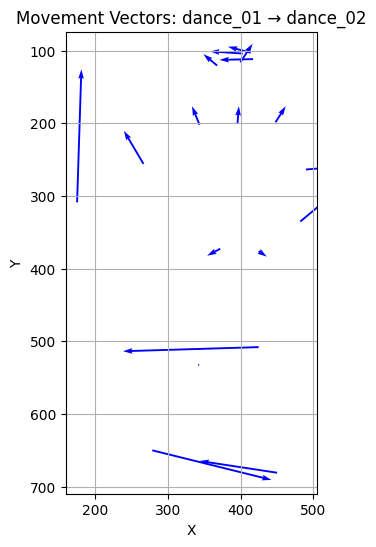

In [35]:
# Visualize the movement between the first two poses
generate_vector_graph(
    pose_list[0],
    poses_to_vectors(pose_list[0], pose_list[1]),
    pose_name1=pose_names[0],
    pose_name2=pose_names[1]
)

## 🤖 Step 3: Train Classifiers

In [40]:
from collections import Counter
print("Training label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

Training label distribution: Counter({5: 13, 4: 9, 0: 4, 1: 3, 3: 3, 2: 3, 6: 1})
Test label distribution: Counter({5: 6, 2: 2, 0: 1})


In [41]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", knn.score(X_test, y_test))

KNN Accuracy: 0.1111111111111111


## 🧪 Step 4: Evaluate Model Performance

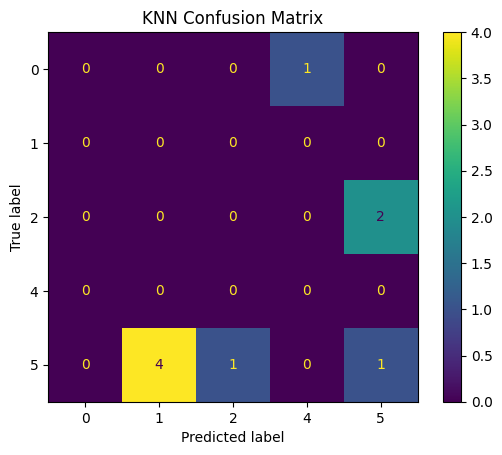

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.33      0.17      0.22         6

    accuracy                           0.11         9
   macro avg       0.07      0.03      0.04         9
weighted avg       0.22      0.11      0.15         9



C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

In [42]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn)
plt.title("KNN Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_test, y_pred_knn))

## Optional: Add Model for Comparison

SVC Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         0
           5       0.75      1.00      0.86         6

    accuracy                           0.67         9
   macro avg       0.19      0.25      0.21         9
weighted avg       0.50      0.67      0.57         9



C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\MissV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

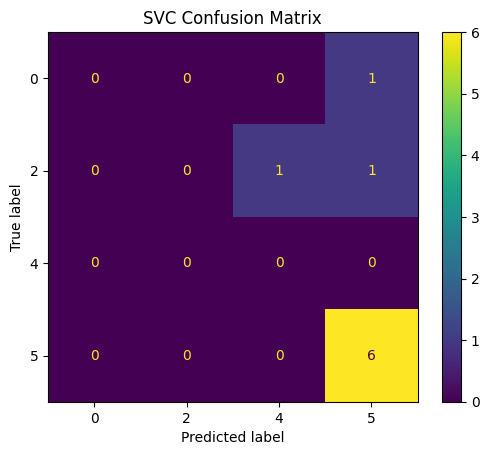

In [43]:
# Compare with SVC classifier
from sklearn.svm import SVC

svc = SVC(kernel='rbf')
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

print("SVC Accuracy:", svc.score(X_test, y_test))
print(classification_report(y_test, y_pred_svc))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc)
plt.title("SVC Confusion Matrix")
plt.show()

## Optional: Visualize Feature Space

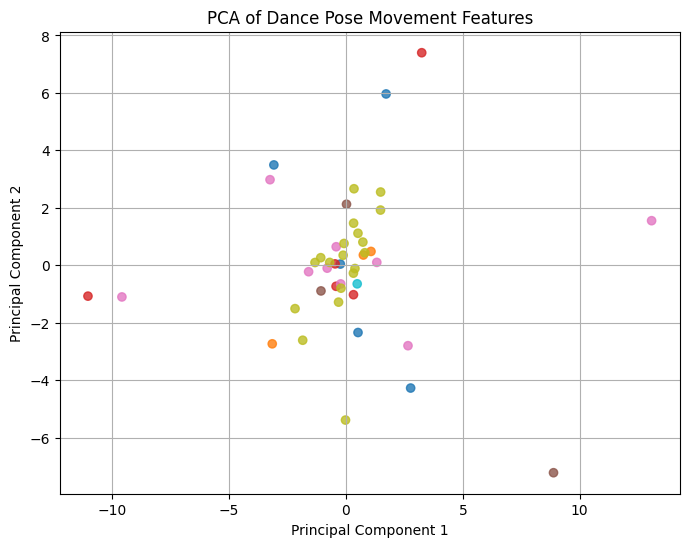

In [44]:
# Visualize feature space using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_2D = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.title("PCA of Dance Pose Movement Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

## 🎓 Summary

In this tutorial, we demonstrated how to classify human dance movements using pose vectors extracted from JSON data. We used Scikit-learn to implement a KNN classifier and evaluated its performance using a confusion matrix and classification report. We also visualized motion between poses using vector arrows and explored dimensionality with PCA. Our data pipeline and labeling strategy were built collaboratively, and we extend special thanks to Hiromi Cota for their work on initial dataset structure and visualization tools.

## 🎓 Conclusion & Next Steps


In this tutorial, we demonstrated a multi-class classification of dance moves using Scikit-learn. We began by loading pose data, engineered features from keypoints, and trained a basic KNN model.

✅ Next steps might include:
- Using real class labels (e.g., "step", "spin", "slide")
- Adding additional models (e.g., SVM with kernel tuning)
- Applying PCA to visualize clusters in 2D

🧠 Stay tuned for TP03: Deep Learning with PyTorch!


## References

- Matthes, E. (2023). *Python Crash Course* (3rd ed.). No Starch Press.  
- Microsoft. (2025). *Fundamentals of Generative AI*. Microsoft Learn. https://learn.microsoft.com  
- OpenAI. (2025). ChatGPT’s assistance with Scikit-learn dance classification [Large language model]. https://openai.com/chatgpt  
- Scikit-learn. (n.d.). User guide. https://scikit-learn.org/stable/user_guide.html  